In [81]:
import numpy as np
import logging
import decimal
import math
from scipy.fftpack import dct

In [82]:
# Round function
def round_half_up(number):
  return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

# Return necessary variables to correlate Greenwood scale with Hertz
def returnValueTuple():
  fmin = 14
  fmax = 12000
  k = 0.88
  A = fmin/(1-k)
  a = math.log10(fmax/A+k)
  return (a,A,k)

# Retreive Greenwood from Hertz
def greenwood_from_hertz(hertz):
  a,A,k = returnValueTuple()
  f = hertz
  return (1/a)*math.log10(f/A+k)

# Retreive Hertz from Greenwood
def hertz_from_greenwood(greenwood):
  a,A,k = returnValueTuple()
  fp = greenwood
  return A*(10**(a*fp)-k)

In [101]:
# NFFT: The size of FFT, It FFT number is less the precision will be less because of dropping many samples; 
#       Using large FFT allows zero padding which is neutral when frequency domain is concerened
#       Here Multiplication by 2 is done which allows some padding but is safe as no sample are dropped 
def calculateNFFTS(sampleRate,windowLength):
  windowLengthSample = windowLength*sampleRate
  nfft = 1
  while nfft < windowLengthSample:
    nfft*=2
  return nfft

# Pre Emphasis: Amplification of high frequencies to balance the frequency spectrum as high frequencies tend to have low magnitude when compared to lower ones
# Formula: x`(n) = x(n) - a*x(n-1) where a = pre-emphasis factor
def preEmphasis(signal,preEmphasisFactor=0.97):
  return np.append(signal[0], signal[1:] - preEmphasisFactor * signal[:-1])

# Numpy stride technique, refer: 
# https://ellisvalentiner.com/post/np-strides-trick/ and
# https://ipython-books.github.io/46-using-stride-tricks-with-numpy/
def rollingWindow(paddedSignal,frameLength,step=1):
    shape = paddedSignal.shape[:-1] + (paddedSignal.shape[-1] - frameLength + 1, frameLength)
    strides = paddedSignal.strides + (paddedSignal.strides[-1],)
    return np.lib.stride_tricks.as_strided(paddedSignal, shape=shape, strides=strides)[::step]

# Cut the signal in frames, frameStep = Number of frames of previous sample after which 2nd sample frames should start, strideTrick uses internal numpy method
def frameSignal(signal, frameLength, frameStep, windowFunction):

  lengthOfSignal = len(signal)
  frameLength = int(round_half_up(frameLength))
  frameStep = int(round_half_up(frameStep))

  if lengthOfSignal < frameLength:
    numberOfFrames = 1
  else:
    numberOfFrames = 1 + int(math.ceil((1.0 * lengthOfSignal - frameLength) / frameStep))

  paddingLength = int((numberOfFrames - 1) * frameStep + frameLength)
  zeros = np.zeros((paddingLength - lengthOfSignal,))
  paddedsignal = np.concatenate((signal, zeros))

  # Use numpy to efficiently make windows
  window = windowFunction(frameLength)
  frames = rollingWindow(paddedsignal,frameLength,step = frameStep)

  return frames * window

# Magnitude Spectrum: Calculated using numpy.fft.rfft' returns the absolute values after taking fourier transfrom
def magSpectrum(frames,nfft):
  if np.shape(frames)[1] > nfft:
    logging.warn('frame length {} is greater than FFT size {}, frame will be truncated. Increase NFFT to avoid.'.format(np.shape(frames)[1],nfft))
  complexSpectrum = np.fft.rfft(frames,nfft)
  return np.absolute(complexSpectrum)

# Power Spectrum: Calulated using 1/n*|si|^2 where 'si' is fourier transform
def powSpectrum(frames,nfft):
  return 1.0/nfft*np.square(magSpectrum(frames,nfft))

# Log power spectrum and normalize
def logPowSpectrum(frames,nfft,normalize = 1):
  powerSpectrum = powSpectrum(frames,nfft)

  # If values are close to 0 or 0 log function will have problem
  powerSpectrum[powerSpectrum<= 1e-30] = 1e-30
  
  logPowerSpectrum = 10*np.log10(powerSpectrum)
  if normalize:
    return logPowerSpectrum - np.max(logPowerSpectrum)
  else:
    return logPowerSpectrum

# Returns Filter Banks: Filters correspond to rows and Columns correspond to fft bins
# returns: array of size = numberOfFilter*(nfft/2+1)
def returnFilterBanks(numberOfFilter=30,nfft=512,sampleRate=16000,lowFrequency=0,highFrequency=None):
  highFrequency= highFrequency or sampleRate/2
  assert highFrequency <= sampleRate/2, "High Frequency is greater than sampleRate/2"

  # Calculate evenly spaced pts in greenwood
  lowGreenWood = greenwood_from_hertz(lowFrequency)
  highGreenWood = greenwood_from_hertz(highFrequency)
  greenWoodPoints = np.linspace(lowGreenWood,highGreenWood,numberOfFilter+2)

  # Current points are in Hertz, but we use fft bins, so we have to convert from Hertz to fft bin number
  bin = np.floor((nfft+1)*hertz_from_greenwood(greenWoodPoints)/sampleRate)

  fbank = np.zeros([numberOfFilter,nfft//2+1])
  for j in range(0,numberOfFilter):
      for i in range(int(bin[j]), int(bin[j+1])):
          fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
      for i in range(int(bin[j+1]), int(bin[j+2])):
          fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
  return fbank


def filterBank(signal,sampleRate=16000, windowLength=0.025, windowStep=0.01, numberOfFilter=30, nfft=512,
               lowFrequency=0, highFrequency=None, preEmphasisFactor=0.97, windowFunction=lambda x: np.ones((x,))):
  
  highFrequency = highFrequency or sampleRate/2
  
  # Step 1: Apply pre emphasis on signal
  signal = preEmphasis(signal,preEmphasisFactor)

  # Step 2: Frame a signal to overlapping signals: 2d nd array
  frames = frameSignal(signal, windowLength*sampleRate, windowStep*sampleRate, windowFunction)

  # Step 3: Calculate the power spectrum
  powerSpec = powSpectrum(frames,nfft)
  
  # Step 4: Calculate the total energy in each frame
  energy = np.sum(powerSpec,1)
  energy = np.where(energy==0,np.finfo(float).eps,energy)

  # Step 5: Get Filter Banks and its energy
  filterBank = returnFilterBanks(numberOfFilter,nfft,sampleRate,lowFrequency,highFrequency)
  features = np.dot(powerSpec,filterBank.T)
  features = np.where(features==0,np.finfo(float).eps,features)

  return features,energy

# Apply liftering: Increases the magnitude of highFrequency DCT coefficients
def lifter(cepstra,lifterParameter=22):
  L = lifterParameter
  if L > 0:
    nframes,ncoeff = np.shape(cepstra)
    n = np.arange(ncoeff)
    lift = 1 + (L/2.)*np.sin(np.pi*n/L)
    return lift*cepstra
  else:
    return cepstra # No liftering



In [102]:
def gfcc(signal,sampleRate = 16000, windowLength = 0.025, windowStep = 0.01, returnCepstrumNumber = 13, 
         numberOfFilter = 30, nfft = None, lowFrequency = 0, highFrequency = None, preEmphasisFactor = 0.97, 
         lifterParameter = 22, appendEnergy = True, windowFunction = lambda x: np.ones((x,))):
  
  # Step 1: Calculate the length of analysis window
  nfft = nfft or calculateNFFTS(sampleRate,windowLength)

  # Step 2 + 3: Calculate Greenwood Filter Bank and apply to power spectrum
  features, energy = filterBank(signal,sampleRate, windowLength,windowStep, numberOfFilter, nfft, lowFrequency, highFrequency, preEmphasisFactor, windowFunction)

  # Step 4: Take log of features
  features = np.log(features)

  # Step 5: Take discrete fourier transform
  features = dct(features,axis=1,norm='ortho')[:,:returnCepstrumNumber]

  # Step 6: Liftering
  features = lifter(features,lifterParameter)

  if appendEnergy:
    features[:,0] = np.log(energy)
  
  return features

In [115]:
from scipy.signal.windows import hann
import scipy.io.wavfile as wav

location = '/content/drive/My Drive/ML_Data/GFCC/english.wav'
sampleRate,signal = wav.read(location)
ggfccFeatures = gfcc(signal,sampleRate,windowFunction=hann)

In [116]:
ggfccFeatures[0]

array([ 12.79466633, -82.58305788, -55.23280006, -57.83718863,
       -52.51790828, -58.81677364, -38.97294579,  -8.49631975,
         3.72433212,   4.44522606, -16.36940895, -43.50342111,
       -80.10249318])

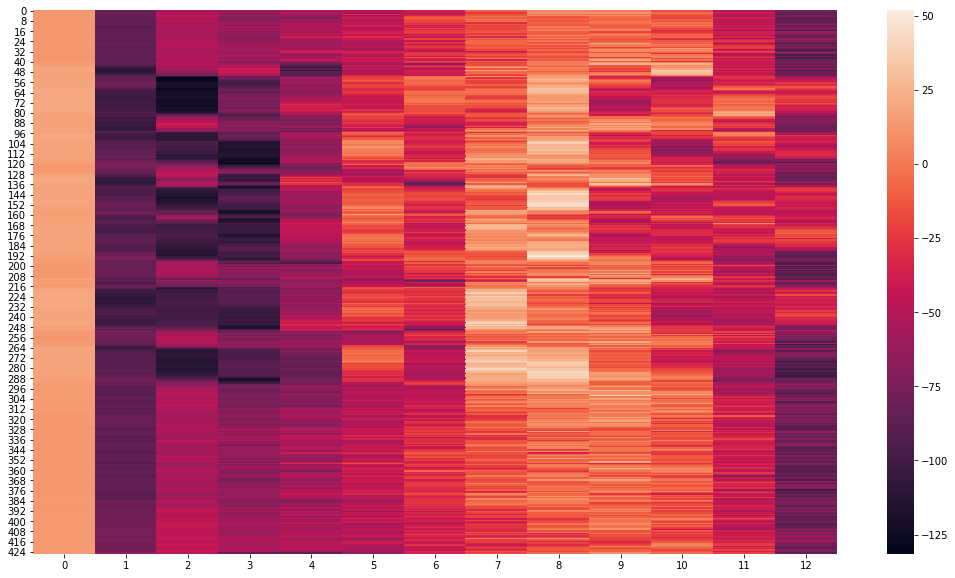

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(18,10))
sns.heatmap(ggfccFeatures)